BRAND CHOICE MODEL

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

WeekMapDF = pd.read_excel('DFs\\WeekMapDF.xlsx')
BeerDF = pd.read_excel('DFs\\BeerDF.xlsx')
CustDemographicDF = pd.read_excel('DFs\\CustDemographicDF.xlsx')
StoreTransactionsDF = pd.read_excel('DFs\\StoreTransactionsDF.xlsx')
CustTransactionsDF = pd.read_excel('DFs\\CustTransactionsDF.xlsx')
BeerTransactionsDF = pd.read_excel('DFs\\BeerTransactionsDF.xlsx')

StoreTransactionsDF = StoreTransactionsDF[StoreTransactionsDF['IRI_KEY'] == 257871]
CustTransactionsDF = CustTransactionsDF[CustTransactionsDF['IRI_KEY'] == 257871]
BeerTransactionsDF = BeerTransactionsDF[BeerTransactionsDF['IRI_KEY'] == 257871]

In [2]:
brand_units_store_257871 = BeerTransactionsDF[BeerTransactionsDF['IRI_KEY']==257871].groupby('BRAND')['BEER_UNITS'].sum().sort_values(ascending=False)
top_4_store = brand_units_store_257871.head(5)
top_4_store

BRAND
MILLER LITE                      400
MILLER GENUINE DRAFT             197
MOUNTAIN CREEK CLASSIC LAGER     167
MILLER GENUINE DRAFT LIGHT 64    165
MICHELOB GOLDEN DRAFT LIGHT      146
Name: BEER_UNITS, dtype: int64

In [16]:
df = BeerTransactionsDF.copy()

df = (df[['PANID','WEEK_DATE','MINUTE','UPC','DAY_OF_WEEK','BRAND','PRICE_PER_OZ']]
      .merge(StoreTransactionsDF[['WEEK_DATE', 'UPC', 'FEATURE', 'DISPLAY', 'PRICE_REDUCTION', 'PROMO']], on=['WEEK_DATE','UPC'], how='inner')
      .merge(CustTransactionsDF[['PANID', 'WEEK_DATE', 'MINUTE', 'TRIP_COST']], on=['PANID', 'WEEK_DATE', 'MINUTE'], how='inner')
      .merge(CustDemographicDF[['PANID', 'INCOME', 'FAMILY_SIZE', 'RESIDENCE_TYPE','AGE_HH', 'EDU_HH', 'OCU_HH', 'DOGS', 'CATS', 'CHILDREN','MARITAL_STATUS', 'RACE']], on='PANID', how='left')
      .merge(WeekMapDF[['WEEK_DATE', 'SEASON']], on='WEEK_DATE', how='left'))

df['PRICE_PER_OZ_x_PROMO'] = df['PRICE_PER_OZ'] * df['PROMO']
df["PROMO_SCORE"] = df["FEATURE"] + df["DISPLAY"] + df["PRICE_REDUCTION"]
df['LOG_PRICE_OZ'] = np.log(df['PRICE_PER_OZ'])
df['LOG_TRIP_COST'] = np.log(df['TRIP_COST'])

# Top Brands
target_brands = [
    "MILLER LITE",
    "MILLER GENUINE DRAFT",
    "MOUNTAIN CREEK CLASSIC LAGER",
    "MILLER GENUINE DRAFT LIGHT 64"
]
df['BRAND_GRP'] = df['BRAND'].apply(lambda x: x if x in target_brands else 'OTHERS')

# Collapse INCOME into 3 bins
def collapse_income(x):
    if x <= 4:   # lowest 4 categories
        return "Low"
    elif x <= 7: # lower middle categories
        return "LowerMid"
    elif x <= 10: # upper middle categories
        return "UpperMid"
    else:        # top income groups
        return "High"

df["INCOME"] = df["INCOME"].apply(collapse_income)

def collapse_children(x):
    if x == 8:
        return "NoChildren"
    elif x in [1, 2, 4, 5]:   # any child under 12
        return "YoungChildren"
    elif x in [3, 6, 7]:      # teens or mix including teens
        return "TeenChildren"
    else:
        return "Other"

df["CHILDREN"] = df["CHILDREN"].map(collapse_children)

In [17]:
# Loyalty Share
temp = BeerTransactionsDF[["PANID","WEEK_DATE","BRAND","BEER_UNITS"]].copy()
W = 12  # rolling weeks

# 1) Aggregate to weekly brand units per PANID (one row per PANID-WEEK-BRAND)
wk = (
    temp.groupby(["PANID","WEEK_DATE","BRAND"], as_index=False)["BEER_UNITS"]
      .sum()
      .rename(columns={"BEER_UNITS":"WEEK_UNITS"})
)

# 2) Build a complete set of calendar weeks and reindex each (PANID, BRAND) series
all_weeks = np.sort(temp["WEEK_DATE"].unique())

def reindex_brand(g):
    g = g.set_index("WEEK_DATE").reindex(all_weeks, fill_value=0)
    g = g.rename_axis("WEEK_DATE").reset_index()
    g["PANID"] = g["PANID"].iat[0]
    g["BRAND"] = g["BRAND"].iat[0]
    return g

wk_full = (
    wk.groupby(["PANID","BRAND"], group_keys=False)
      .apply(reindex_brand)
)

# 3) Rolling sums over the LAST W calendar weeks (shifted so we don’t peek at week t)
wk_full["ROLL_BRAND"] = (
    wk_full.groupby(["PANID","BRAND"])["WEEK_UNITS"]
      .transform(lambda x: x.rolling(W, min_periods=1).sum())
)
wk_full["ROLL_BRAND"] = (
    wk_full.groupby(["PANID","BRAND"])["ROLL_BRAND"].shift(1).fillna(0)
)

# 4) Rolling total units across ALL brands for each PANID
tot = (
    wk_full.groupby(["PANID","WEEK_DATE"], as_index=False)["WEEK_UNITS"]
           .sum()
           .rename(columns={"WEEK_UNITS":"WEEK_UNITS_TOTAL"})
)
tot["ROLL_TOTAL"] = (
    tot.groupby("PANID")["WEEK_UNITS_TOTAL"]
       .transform(lambda x: x.rolling(W, min_periods=1).sum())
)
tot["ROLL_TOTAL"] = tot.groupby("PANID")["ROLL_TOTAL"].shift(1).fillna(0)

# 5) Merge totals back and compute loyalty share
wk_full = wk_full.merge(tot[["PANID","WEEK_DATE","ROLL_TOTAL"]], on=["PANID","WEEK_DATE"], how="left")

# Use the merged column on wk_full, not the original 'tot' frame
wk_full["LOYALTY_SHARE"] = wk_full["ROLL_BRAND"] / wk_full["ROLL_TOTAL"].replace(0, np.nan)
wk_full["LOYALTY_SHARE"] = wk_full["LOYALTY_SHARE"].fillna(0.0).clip(0, 1)

# 6) Attach to the transaction rows you’ll model (PANID, WEEK, BRAND)
df = df.merge(wk_full[["PANID","WEEK_DATE","BRAND","LOYALTY_SHARE"]],on=["PANID","WEEK_DATE","BRAND"],how="left").assign(LOYALTY_SHARE=lambda d: d["LOYALTY_SHARE"].fillna(0.0))

C:\Users\wayne\AppData\Local\Temp\ipykernel_2884\288415141.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reindex_brand)


In [18]:
beer_df_small = BeerTransactionsDF[["UPC", "BRAND"]].drop_duplicates()
store_df = StoreTransactionsDF.merge(beer_df_small, on="UPC", how="left")
store_df = store_df.dropna(subset=["BRAND"])

AGG_MODE = "weighted"

def _agg_share(flag_col, g):
    # Unit-weighted share of items on promo in that brand-week
    denom = g["__w__"].sum()
    if denom <= 0:
        return 0.0
    return (g[flag_col] * g["__w__"]).sum() / denom

def _agg_binary(flag_col, g):
    return int(g[flag_col].max())

store_df["__w__"] = store_df["UNITS"].fillna(0).clip(lower=0)

group_cols = ["WEEK_DATE", "BRAND"]
promo_cols = ["FEATURE", "DISPLAY", "PRICE_REDUCTION", "PROMO"]

if AGG_MODE == "weighted":
    brand_week = (
        store_df
        .groupby(group_cols, as_index=False)
        .apply(lambda g: pd.Series({
            "FEATURE_INTENSITY": _agg_share("FEATURE", g),
            "DISPLAY_INTENSITY": _agg_share("DISPLAY", g),
            "PRICERED_INTENSITY": _agg_share("PRICE_REDUCTION", g),
            "PROMO_INTENSITY":   _agg_share("PROMO", g),
        }),include_groups=False)
        .reset_index(drop=True)
    )
else:
    brand_week = (
        store_df
        .groupby(group_cols, as_index=False)
        .agg({
            "FEATURE": "max",
            "DISPLAY": "max",
            "PRICE_REDUCTION": "max",
            "PROMO": "max"
        })
        .rename(columns={
            "FEATURE":"FEATURE_INTENSITY",
            "DISPLAY":"DISPLAY_INTENSITY",
            "PRICE_REDUCTION":"PRICERED_INTENSITY",
            "PROMO":"PROMO_INTENSITY"
        })
    )

# ------------------------------
# 4) Fill missing weeks so adstock can "carry" across gaps
#    We reindex each BRAND over the full week range seen in this store
# ------------------------------
full_week = pd.Index(sorted(store_df["WEEK_DATE"].unique()), name="WEEK_DATE")

def fill_weeks(g):
    brand = getattr(g, "name", None)           # get group key when BRAND col is excluded
    g = g.set_index("WEEK_DATE").reindex(full_week)
    if "BRAND" in g.columns:                   # keep current behavior if present
        g["BRAND"] = g["BRAND"].ffill().bfill()
    else:
        g["BRAND"] = brand                     # otherwise, fill from group key
    return g.reset_index()

brand_week = (
    brand_week
    .groupby("BRAND", as_index=False, group_keys=True)
    .apply(fill_weeks, include_groups=False)    # <-- add this
    .reset_index(drop=True)
)

# Replace NaNs in intensities with 0 (no promo exposure that week)
for c in ["FEATURE_INTENSITY", "DISPLAY_INTENSITY", "PRICERED_INTENSITY", "PROMO_INTENSITY"]:
    brand_week[c] = brand_week[c].fillna(0.0)

# ------------------------------
# 5) Adstock function (geometric, carryover)
#    adstock_t = x_t + decay * adstock_{t-1}
# ------------------------------
def adstock(series: pd.Series, decay: float) -> pd.Series:
    out = np.zeros(len(series), dtype=float)
    carry = 0.0
    vals = series.to_numpy(dtype=float)
    for i, x in enumerate(vals):
        out[i] = x + decay * carry
        carry = out[i]
    return pd.Series(out, index=series.index)

# Choose per-promo decays (tune as needed)
DECAYS = {
    "FEATURE_INTENSITY": 0.50,
    "DISPLAY_INTENSITY": 0.40,
    "PRICERED_INTENSITY": 0.60,
    "PROMO_INTENSITY": 0.55,
}

# Apply adstock per BRAND over time (sorted by WEEK)
def apply_adstock(g):
    g = g.sort_values("WEEK_DATE").copy()
    for col, d in DECAYS.items():
        g[f"AD_{col}"] = adstock(g[col], d)
    return g

brand_week_ad = (
    brand_week
    .groupby("BRAND", as_index=False, group_keys=True)
    .apply(apply_adstock)
    .reset_index(drop=True)
)

df = df.merge(brand_week_ad[["WEEK_DATE", "BRAND","AD_FEATURE_INTENSITY", "AD_DISPLAY_INTENSITY","AD_PRICERED_INTENSITY", "AD_PROMO_INTENSITY"]],
              on=["WEEK_DATE","BRAND"], how="left")


df.head()

C:\Users\wayne\AppData\Local\Temp\ipykernel_2884\2039905212.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_adstock)


,PANID,WEEK_DATE,MINUTE,UPC,DAY_OF_WEEK,BRAND,PRICE_PER_OZ,FEATURE,DISPLAY,PRICE_REDUCTION,PROMO,TRIP_COST,INCOME,FAMILY_SIZE,RESIDENCE_TYPE,AGE_HH,EDU_HH,OCU_HH,DOGS,CATS,CHILDREN,MARITAL_STATUS,RACE,SEASON,PRICE_PER_OZ_x_PROMO,PROMO_SCORE,LOG_PRICE_OZ,LOG_TRIP_COST,BRAND_GRP,LOYALTY_SHARE,AD_FEATURE_INTENSITY,AD_DISPLAY_INTENSITY,AD_PRICERED_INTENSITY,AD_PROMO_INTENSITY
0,3822619,2009-02-02,9334,11497450009,6,WOODCHUCK DRAFT CIDER AMBER,0.540833,0,1,1,1,99.631680,UpperMid,5,1,4,5,3,1,1,TeenChildren,1,1,Winter,0.540833,2,-0.614644,4.601480,OTHERS,0.0,0.000000,1.000000,1.000000,1.000000
1,3822619,2009-04-13,6445,11497480009,4,WOODCHUCK DRAFT CIDER,0.536667,1,0,1,1,72.080000,UpperMid,5,1,4,5,3,1,1,TeenChildren,1,1,Spring,0.536667,2,-0.622378,4.277777,OTHERS,0.0,1.001953,0.000000,1.886936,1.735027
2,3108126,2009-09-14,8262,11820000106,5,BUD LIGHT,0.440833,0,0,0,0,33.979189,Low,2,1,6,6,10,0,0,NoChildren,1,1,Fall,0.000000,0,-0.819088,3.525748,OTHERS,0.0,0.003174,0.537170,0.394713,1.019727
3,3138875,2009-02-02,6643,11820000106,4,BUD LIGHT,0.415833,0,0,0,0,6.758999,UpperMid,2,1,5,3,8,0,0,NoChildren,1,1,Winter,0.000000,0,-0.877471,1.910875,OTHERS,0.0,0.698610,1.015895,1.114077,1.366219
4,3354118,2009-04-13,9616,11820000106,6,BUD LIGHT,0.415833,0,0,0,0,29.019595,LowerMid,2,1,6,5,9,0,0,NoChildren,1,1,Spring,0.000000,0,-0.877471,3.367971,OTHERS,0.0,0.414849,0.611855,0.338434,1.463647


In [28]:
# Correlation matrix
import matplotlib.pyplot as plt

numeric_df = df[['PANID', 'WEEK_DATE', 'MINUTE', 'UPC', 'DAY_OF_WEEK', 'BRAND',
       'PRICE_PER_OZ', 'FEATURE', 'DISPLAY', 'PRICE_REDUCTION', 'PROMO',
       'TRIP_COST', 'INCOME', 'FAMILY_SIZE', 'RESIDENCE_TYPE', 'AGE_HH',
       'EDU_HH', 'OCU_HH', 'DOGS', 'CATS', 'CHILDREN', 'MARITAL_STATUS',
       'RACE', 'SEASON', 'PRICE_PER_OZ_x_PROMO', 'PROMO_SCORE', 'LOG_PRICE_OZ',
       'LOG_TRIP_COST', 'BRAND_GRP', 'LOYALTY_SHARE', 'AD_FEATURE_INTENSITY',
       'AD_DISPLAY_INTENSITY', 'AD_PRICERED_INTENSITY', 'AD_PROMO_INTENSITY']].select_dtypes(include='number')
corr_matrix = numeric_df.corr()
print(corr_matrix)

'''# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()'''

                          PANID    MINUTE       UPC  DAY_OF_WEEK  \
PANID                  1.000000  0.036441  0.029575     0.037950   
MINUTE                 0.036441  1.000000  0.013649     0.997903   
UPC                    0.029575  0.013649  1.000000     0.009910   
DAY_OF_WEEK            0.037950  0.997903  0.009910     1.000000   
PRICE_PER_OZ          -0.078436 -0.038283 -0.282875    -0.035509   
FEATURE                0.015003 -0.127395 -0.079884    -0.125509   
DISPLAY               -0.002823  0.043302 -0.073368     0.041425   
PRICE_REDUCTION        0.006329  0.051626 -0.026335     0.049186   
PROMO                  0.009014  0.019453 -0.067454     0.017674   
TRIP_COST              0.013623  0.048430 -0.084689     0.046074   
FAMILY_SIZE           -0.087902  0.068713  0.043987     0.060036   
RESIDENCE_TYPE        -0.018067  0.023902 -0.023852     0.018460   
AGE_HH                 0.043034 -0.133377  0.027489    -0.119354   
EDU_HH                -0.085553  0.041653 -0.027

'# Plot heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\', center=0)\nplt.title(\'Correlation Matrix\')\nplt.show()'

In [ ]:
# === Multinomial Logistic (scikit-learn) ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# 1) START FROM YOUR BASE DF AND FEATURES (same as your code)
base = df.copy()
base = base.sort_values(["BRAND_GRP", "WEEK_DATE"])

# Feature engineering (same)
base["AD_PROMO_INTENSITY_LAG1"] = (base.groupby("BRAND_GRP")["AD_PROMO_INTENSITY"].shift(1).fillna(0.0))
base["AD_FEATURE_INTENSITY_LAG1"] = (base.groupby("BRAND_GRP")["AD_FEATURE_INTENSITY"].shift(1).fillna(0.0))
base["AD_PRICERED_INTENSITY_LAG1"] = (base.groupby("BRAND_GRP")["AD_PRICERED_INTENSITY"].shift(1).fillna(0.0))
base["LOYALTY_X_PRICE"] = base["LOYALTY_SHARE"] * base["LOG_PRICE_OZ"]
base["PRICE_X_PROMO"]   = base["LOG_PRICE_OZ"] * base["AD_PROMO_INTENSITY_LAG1"]

# Target with your class order
y = base["BRAND_GRP"].astype("category")
y = y.cat.reorder_categories(["OTHERS", "MILLER LITE","MILWAUKEES BEST LIGHT","MICHELOB GOLDEN DRAFT LIGHT",],ordered=True)

# Columns (note: we'll scale inside the pipeline, no manual scaling first)
num_cols = [
    "AD_FEATURE_INTENSITY_LAG1","AD_PRICERED_INTENSITY_LAG1", "LOG_PRICE_OZ", "LOYALTY_SHARE",
    "LOG_TRIP_COST", "LOYALTY_X_PRICE", "PRICE_X_PROMO"
]
cat_cols = ["INCOME"]

# 2) Preprocess + Model (pipeline)
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

clf = Pipeline(
    steps=[
        ("prep", pre),
        ("lr", LogisticRegression(
    penalty="l2",      # Ridge
    C=1.0,             # Regularization strength (lower = more penalty)
    solver="lbfgs",
    max_iter=2000
    ))
    ]
)

# 3) Fit
X = base[num_cols + cat_cols]
clf.fit(X, y)

# 4) Quick metrics (in-sample)
probs = clf.predict_proba(X)
preds = clf.predict(X)
print("Accuracy:", accuracy_score(y, preds))
print("LogLoss :", log_loss(y, probs))

# 5) Coefficients tidy table
feature_names = clf.named_steps["prep"].get_feature_names_out()
coefs = clf.named_steps["lr"].coef_          # shape: [n_classes, n_features]
classes = clf.named_steps["lr"].classes_

coef_df = (
    pd.DataFrame(coefs, index=classes, columns=feature_names)
      .T.reset_index().rename(columns={"index":"Feature"})
)
print(coef_df)

Accuracy: 0.7680574248541947
LogLoss : 0.7479897765378769
                Feature  MILLER GENUINE DRAFT  MILLER GENUINE DRAFT LIGHT 64  \
0          num__FEATURE              0.192281                       0.296660   
1  num__PRICE_REDUCTION              0.123664                       0.169193   
2          num__DISPLAY              0.629488                       0.298295   
3     num__LOG_PRICE_OZ              0.227792                       0.341540   
4    num__LOYALTY_SHARE              0.063204                      -0.409360   
5  num__LOYALTY_X_PRICE              1.306846                      -0.204414   
6    num__PRICE_X_PROMO             -0.239562                      -0.210098   
7       cat__INCOME_Low             -0.968564                      -1.065187   
8  cat__INCOME_LowerMid              0.137692                      -0.530448   
9  cat__INCOME_UpperMid              0.101092                      -0.317593   

   MILLER LITE  MOUNTAIN CREEK CLASSIC LAGER    OTHERS  
0   

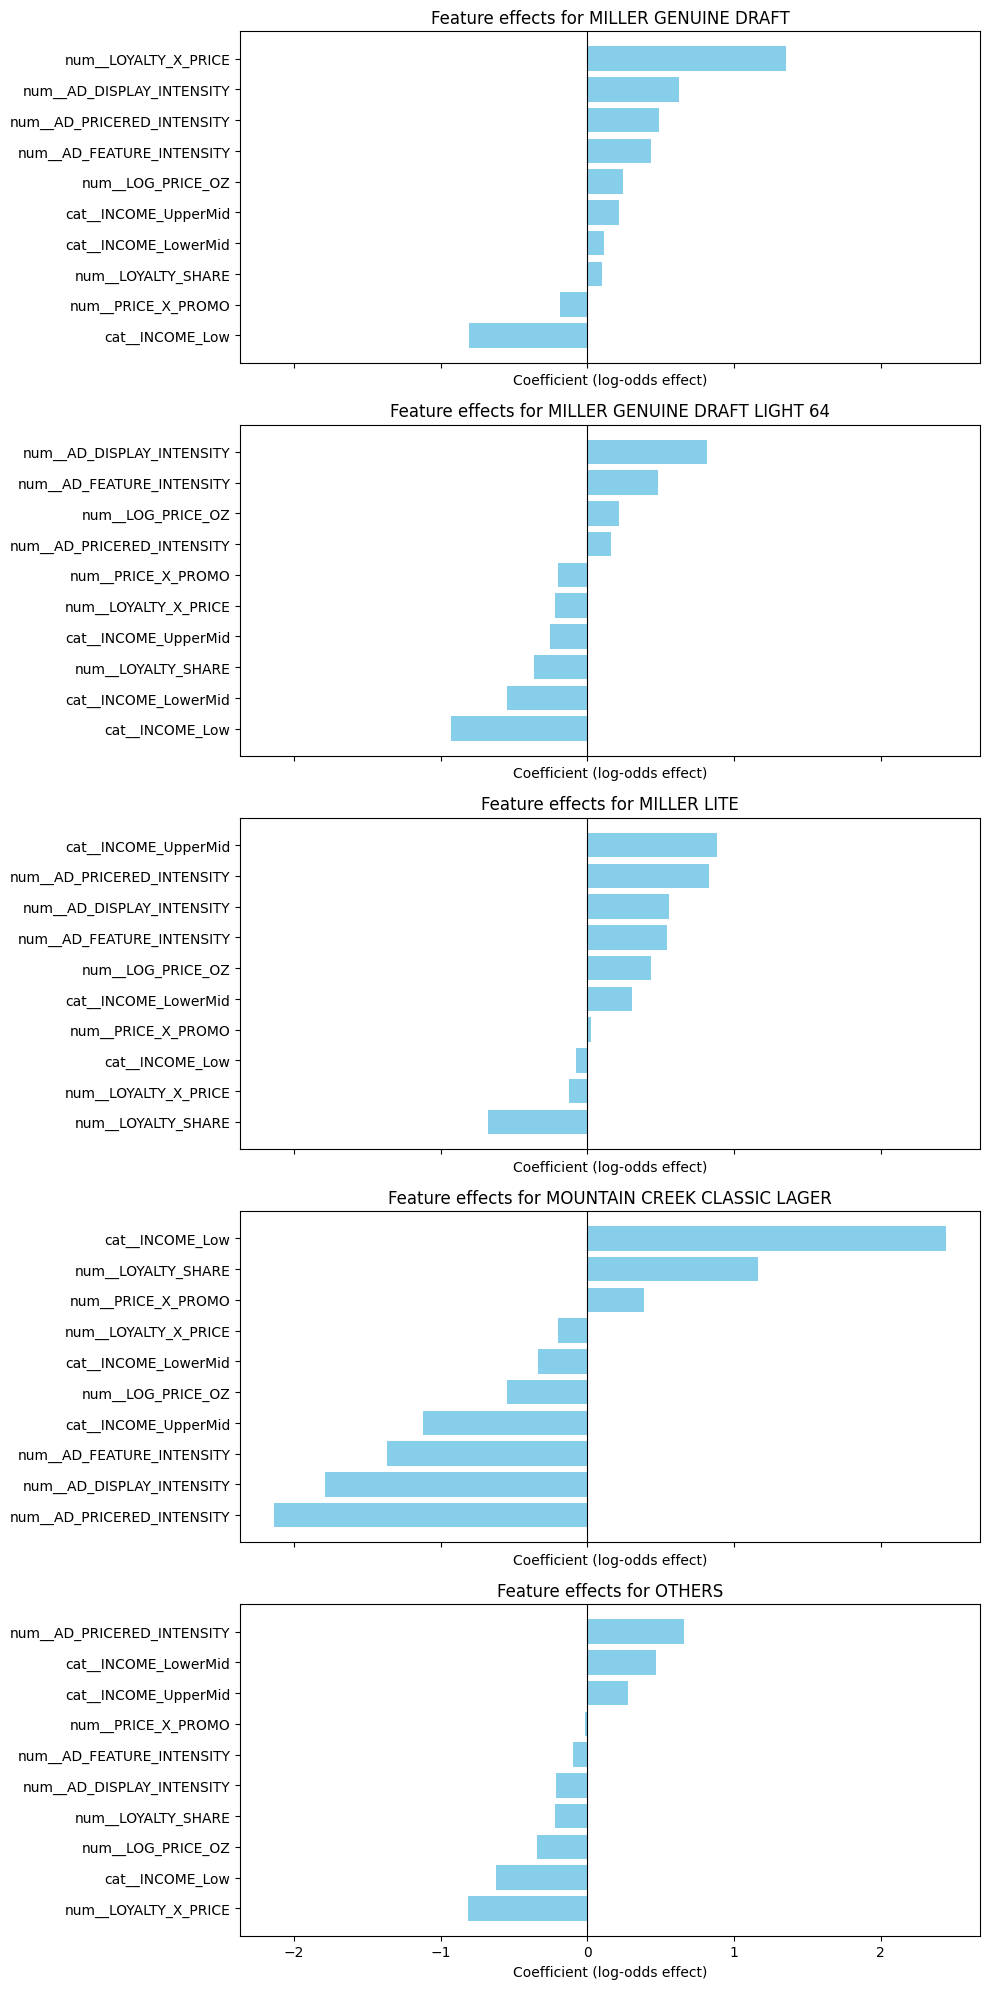

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract coefficients
feature_names = clf.named_steps["prep"].get_feature_names_out()
coefs = clf.named_steps["lr"].coef_          # shape: [n_classes, n_features]
classes = clf.named_steps["lr"].classes_

coef_df = pd.DataFrame(coefs.T, index=feature_names, columns=classes)

# Plot coefficients for each brand
fig, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(10, 4*len(classes)), sharex=True)

if len(classes) == 1:
    axes = [axes]

for ax, brand in zip(axes, classes):
    data = coef_df[brand].sort_values()
    ax.barh(data.index, data.values, color="skyblue")
    ax.axvline(0, color="black", linewidth=0.8)
    ax.set_title(f"Feature effects for {brand}")
    ax.set_xlabel("Coefficient (log-odds effect)")

plt.tight_layout()
plt.show()


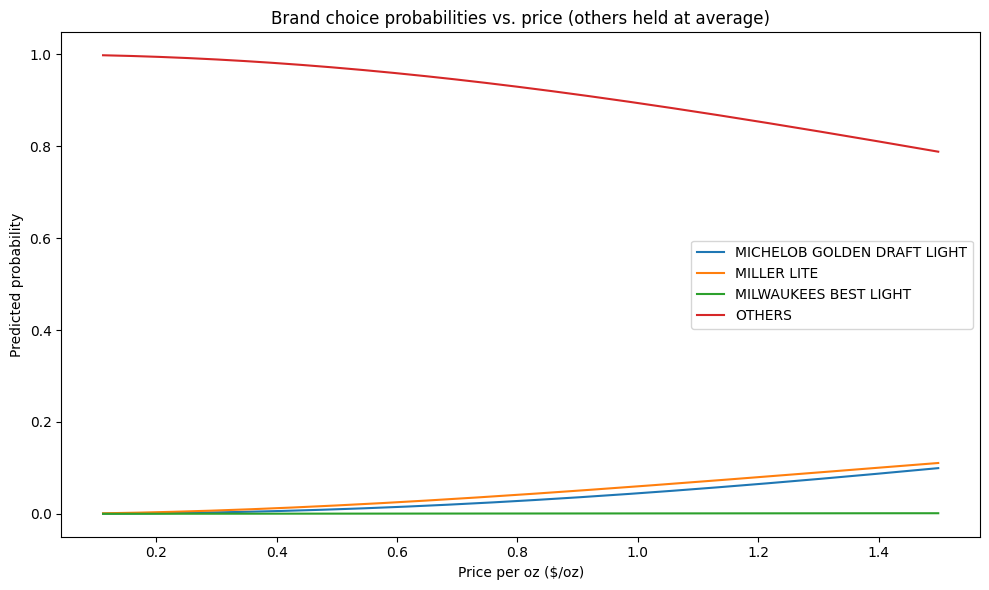

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# classes order
classes = clf.named_steps["lr"].classes_

# Build an "average" row for all features (raw scale; pipeline will transform)
num_cols = ["AD_FEATURE_INTENSITY_LAG1","AD_PRICERED_INTENSITY_LAG1","AD_PROMO_INTENSITY_LAG1","LOG_PRICE_OZ","LOYALTY_SHARE",
            "LOG_TRIP_COST","LOYALTY_X_PRICE","PRICE_X_PROMO"]
cat_cols = ["INCOME"]

avg = {}
for c in num_cols:
    avg[c] = base[c].mean()
for c in cat_cols:
    avg[c] = base[c].mode(dropna=True).iat[0]

# Price grid in raw log-price space, then convert to $/oz for axis
logp_min, logp_max = base["LOG_PRICE_OZ"].quantile([0.01, 0.99]).to_numpy()
log_price_grid = np.linspace(logp_min, logp_max, 150)
price_per_oz = np.exp(log_price_grid)

# Create design grid
grid = pd.DataFrame([avg]*len(log_price_grid))
grid["LOG_PRICE_OZ"] = log_price_grid
# keep consistency for cross-terms if present
grid["LOYALTY_X_PRICE"] = grid["LOYALTY_SHARE"] * grid["LOG_PRICE_OZ"]
grid["PRICE_X_PROMO"]   = grid["LOG_PRICE_OZ"] * grid["AD_PROMO_INTENSITY_LAG1"]

# Predict through the pipeline
probs = clf.predict_proba(grid)  # ndarray [n_points x n_classes]

# Plot
plt.figure(figsize=(10,6))
for j, br in enumerate(classes):
    plt.plot(price_per_oz, probs[:, j], label=br)
plt.xlabel("Price per oz ($/oz)")
plt.ylabel("Predicted probability")
plt.title("Brand choice probabilities vs. price (others held at average)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# === MNLogit (Brand Choice)
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

base = df.copy()

base = base.sort_values(["BRAND_GRP", 'WEEK_DATE'])
base["AD_PROMO_INTENSITY_LAG1"] = (base.groupby("BRAND_GRP")["AD_PROMO_INTENSITY"].shift(1).fillna(0.0))
base["LOYALTY_X_PRICE"] = base["LOYALTY_SHARE"] * base["LOG_PRICE_OZ"]
base["PRICE_X_PROMO"] = base["LOG_PRICE_OZ"] * base["AD_PROMO_INTENSITY_LAG1"]

y = ['BRAND_GRP']

numeric = ['AD_PROMO_INTENSITY_LAG1','LOG_PRICE_OZ','LOYALTY_SHARE','LOG_TRIP_COST','LOYALTY_X_PRICE','PRICE_X_PROMO']
X_num = base[numeric]
X_num = pd.DataFrame(StandardScaler().fit_transform(X_num),columns=X_num.columns, index=X_num.index)

col_cat = ['INCOME']
X_cat = base[col_cat].astype('category')
X_cat = pd.get_dummies(X_cat, drop_first=True).astype(int)

# 9) Final X and y
X = pd.concat([X_num, X_cat], axis=1)
X = sm.add_constant(X, prepend=False)
y = base["BRAND_GRP"].astype("category")
y = y.cat.reorder_categories(["OTHERS","MILLER LITE","MICHELOB GOLDEN DRAFT LIGHT","MILWAUKEES BEST LIGHT"], ordered=True)


model = sm.MNLogit(y, X)
res = model.fit(method="bfgs", maxiter=500, gtol=1e-6)
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.555944
         Iterations: 222
         Function evaluations: 223
         Gradient evaluations: 223
                          MNLogit Regression Results                          
Dep. Variable:              BRAND_GRP   No. Observations:                 2229
Model:                        MNLogit   Df Residuals:                     2199
Method:                           MLE   Df Model:                           27
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.2234
Time:                        03:19:06   Log-Likelihood:                -1239.2
converged:                       True   LL-Null:                       -1595.7
Covariance Type:            nonrobust   LLR p-value:                7.184e-133
                BRAND_GRP=MILLER LITE       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

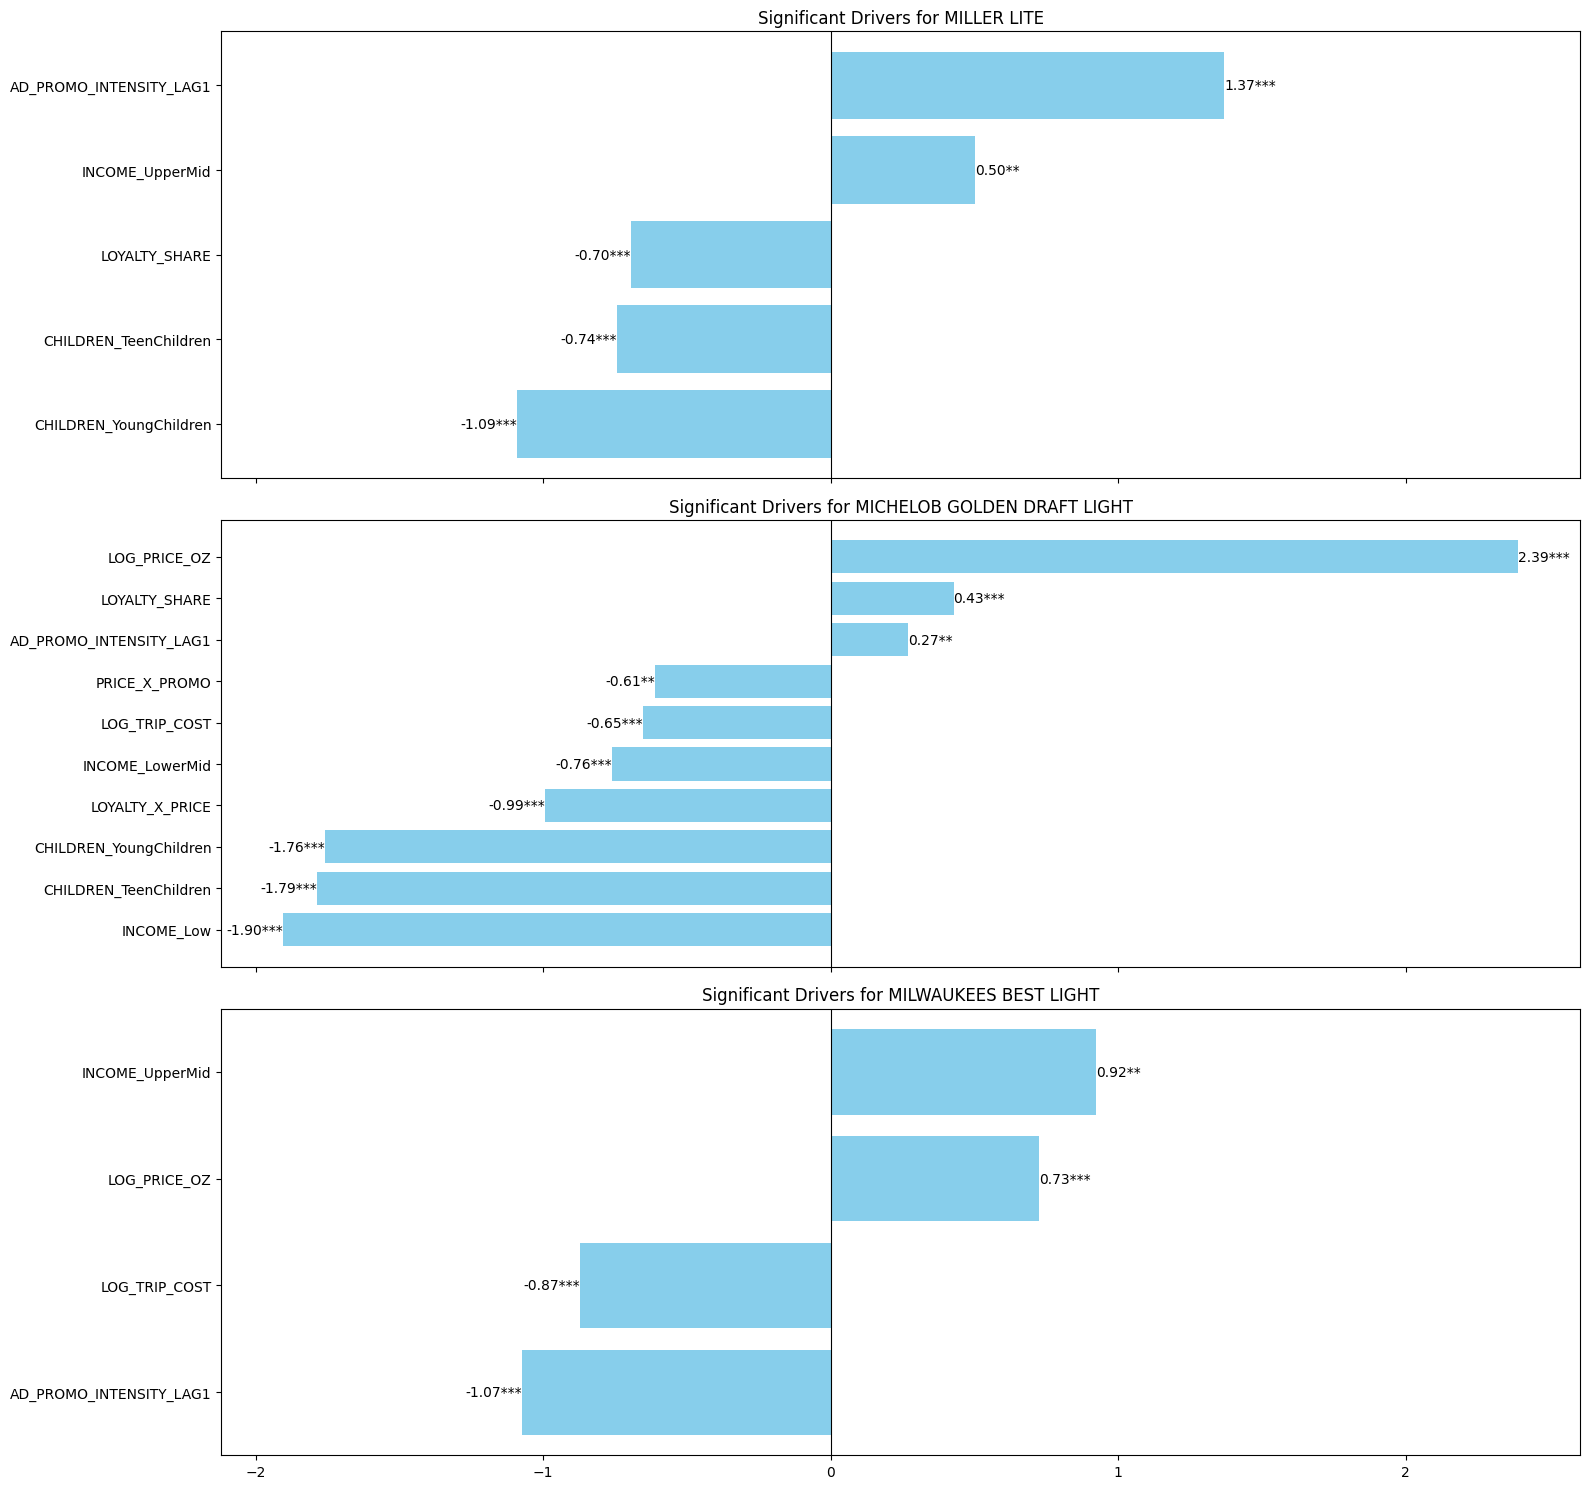

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Recreate coefficients and p-values from summary
data = {
    "Brand": ["MILLER LITE"]*11 + ["MICHELOB GOLDEN DRAFT LIGHT"]*11 + ["MILWAUKEES BEST LIGHT"]*11,
    "Variable": [
        "AD_PROMO_INTENSITY_LAG1","LOG_PRICE_OZ","LOYALTY_SHARE","LOG_TRIP_COST","LOYALTY_X_PRICE","PRICE_X_PROMO",
        "INCOME_Low","INCOME_LowerMid","INCOME_UpperMid","CHILDREN_TeenChildren","CHILDREN_YoungChildren",
        "AD_PROMO_INTENSITY_LAG1","LOG_PRICE_OZ","LOYALTY_SHARE","LOG_TRIP_COST","LOYALTY_X_PRICE","PRICE_X_PROMO",
        "INCOME_Low","INCOME_LowerMid","INCOME_UpperMid","CHILDREN_TeenChildren","CHILDREN_YoungChildren",
        "AD_PROMO_INTENSITY_LAG1","LOG_PRICE_OZ","LOYALTY_SHARE","LOG_TRIP_COST","LOYALTY_X_PRICE","PRICE_X_PROMO",
        "INCOME_Low","INCOME_LowerMid","INCOME_UpperMid","CHILDREN_TeenChildren","CHILDREN_YoungChildren"
    ],
    "Coef": [
        1.3686,0.4814,-0.6959,-0.1146,0.6805,0.2962,0.2792,-0.2846,0.5008,-0.7440,-1.0915,
        0.2695,2.3912,0.4271,-0.6528,-0.9946,-0.6124,-1.9049,-0.7605,-0.3710,-1.7883,-1.7596,
        -1.0729,0.7252,-20.3513,-0.8718,-0.6487,-0.4141,-0.3660,-0.8587,0.9222,0.1365,-25.1555
    ],
    "pval": [
        0.000,0.171,0.000,0.152,0.292,0.167,0.275,0.216,0.022,0.009,0.009,
        0.011,0.000,0.000,0.000,0.000,0.025,0.000,0.008,0.209,0.004,0.001,
        0.000,0.007,0.995,0.000,1.000,0.126,0.551,0.134,0.049,0.728,1.000
    ]
}

coef_df = pd.DataFrame(data)

# Add significance stars
def significance_stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return ""

coef_df["Signif"] = coef_df["pval"].apply(significance_stars)

# Keep significant variables only
sig_df = coef_df[coef_df["pval"] < 0.05]

# Plot
brands = sig_df["Brand"].unique()
fig, axes = plt.subplots(nrows=len(brands), ncols=1, figsize=(16, 5*len(brands)), sharex=True)

if len(brands) == 1:
    axes = [axes]

for ax, brand in zip(axes, brands):
    data = sig_df[sig_df["Brand"] == brand].sort_values("Coef")
    ax.barh(data["Variable"], data["Coef"], color="skyblue")
    for i, (coef, signif) in enumerate(zip(data["Coef"], data["Signif"])):
        ax.text(coef, i, f"{coef:.2f}{signif}", va="center",
                ha="left" if coef > 0 else "right")
    ax.axvline(0, color="black", linewidth=0.8)
    ax.set_title(f"Significant Drivers for {brand}")

plt.tight_layout()
plt.show()
